In [2]:
import simpy

## BASIC1

In [1]:
# https://simpy.readthedocs.io/en/latest/simpy_intro/process_interaction.html

import simpy
SIM_TIME = 20

def car(env):
    while True:
        print('Start parking at %d' % env.now)
        parking_duration = 5
        yield env.timeout(parking_duration)

        print('Start driving at %d' % env.now)
        trip_duration = 2
        yield env.timeout(trip_duration) #function to create a Timeout event (wait) 

env = simpy.Environment()
env.process(car(env))

env.run(until=SIM_TIME)


Start parking at 0
Start driving at 5
Start parking at 7
Start driving at 12
Start parking at 14
Start driving at 19


## BASIC2 - classe

In [10]:
# https://simpy.readthedocs.io/en/latest/simpy_intro/process_interaction.html
# unica differenza la classe come contenitore di diverse funzioni e il ciclo run che richiama altre funzioni 

import simpy
SIM_TIME = 20

class Car(object):
    def __init__(self, env):
        self.env = env          # Start the run process everytime an instance is created.
        self.action = env.process(self.run())

    def run(self):
        while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5
            yield self.env.process(self.charge(charge_duration))

            print('Start driving at %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def charge(self, duration):
        yield self.env.timeout(duration)

env = simpy.Environment()
car = Car(env)

env.run(until=SIM_TIME)


Start parking and charging at 0
Start driving at 5
Start parking and charging at 7
Start driving at 12
Start parking and charging at 14
Start driving at 19


## BASIC3 - INTERRUZIONE 
#### capire perche solo UNA interruzione all'inizio 

In [5]:
# https://simpy.readthedocs.io/en/latest/simpy_intro/process_interaction.html
# INTERRUZIONE 

import simpy
SIM_TIME = 20

class Car(object):
    def __init__(self, env):
        self.env = env          # Start the run process everytime an instance is created.
        self.action = env.process(self.run())

    def run(self):
        while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5

            try:
                yield self.env.process(self.charge(charge_duration))
            except simpy.Interrupt:
                # When we received an interrupt, we stop charging and switch to the "driving" state
                print('Was interrupted. Hope, the battery is full enough ...')            

            print('Start driving at %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def charge(self, duration):
        yield self.env.timeout(duration)

def driver(env, car):
    yield env.timeout(3)
    car.action.interrupt()
        
env = simpy.Environment()
car = Car(env)
env.process(driver(env, car))
env.run(until=15)


Start parking and charging at 0
Was interrupted. Hope, the battery is full enough ...
Start driving at 3
Start parking and charging at 5
Start driving at 10
Start parking and charging at 12


## BASIC4 - Basic Resource Usage 


In [59]:
#https://simpy.readthedocs.io/en/latest/simpy_intro/shared_resources.html

import simpy
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)


def car(env, name, bcs, driving_time, charge_duration,carnum):
    yield env.timeout(driving_time)     # Simulate driving to the BCS

    print(env.now,'(+)',('--'*carnum),'%s arriving at %d' % (name, env.now))     # Request one of its charging spots
    with bcs.request() as req:
        yield req
        print(env.now,'(b)',('--'*carnum),'%s starting to charge at %s' % (name, env.now))
        yield env.timeout(charge_duration)
        print(env.now,'(-)',('--'*carnum),'%s leaving the bcs at %s' % (name, env.now))

for i in range(10):
    env.process(car(env, 'Car %d' % i, bcs, i*2, 7,i))

env.run(until=25)


0 (+)  Car 0 arriving at 0
0 (b)  Car 0 starting to charge at 0
2 (+) -- Car 1 arriving at 2
2 (b) -- Car 1 starting to charge at 2
4 (+) ---- Car 2 arriving at 4
6 (+) ------ Car 3 arriving at 6
7 (-)  Car 0 leaving the bcs at 7
7 (b) ---- Car 2 starting to charge at 7
8 (+) -------- Car 4 arriving at 8
9 (-) -- Car 1 leaving the bcs at 9
9 (b) ------ Car 3 starting to charge at 9
10 (+) ---------- Car 5 arriving at 10
12 (+) ------------ Car 6 arriving at 12
14 (+) -------------- Car 7 arriving at 14
14 (-) ---- Car 2 leaving the bcs at 14
14 (b) -------- Car 4 starting to charge at 14
16 (+) ---------------- Car 8 arriving at 16
16 (-) ------ Car 3 leaving the bcs at 16
16 (b) ---------- Car 5 starting to charge at 16
18 (+) ------------------ Car 9 arriving at 18
21 (-) -------- Car 4 leaving the bcs at 21
21 (b) ------------ Car 6 starting to charge at 21
23 (-) ---------- Car 5 leaving the bcs at 23
23 (b) -------------- Car 7 starting to charge at 23


# Bank Renege . 
- random exit criteria
- Queue visibility
- Sym metrics
### https://simpy.readthedocs.io/en/latest/examples/bank_renege.html

Bank renege
NEW_CUSTOMERS,INTERVAL_CUSTOMERS,CAPACITY,MIN_PATIENCE,MAX_PATIENCE
20 2.0 2 5 10
PRINTALL: N
TOT_CUSTOMER: 20
TOT_COMPLETED: 11
TOT_RENEGED: 9
%SUCCESS: 0.55
maxQUEUE: 6


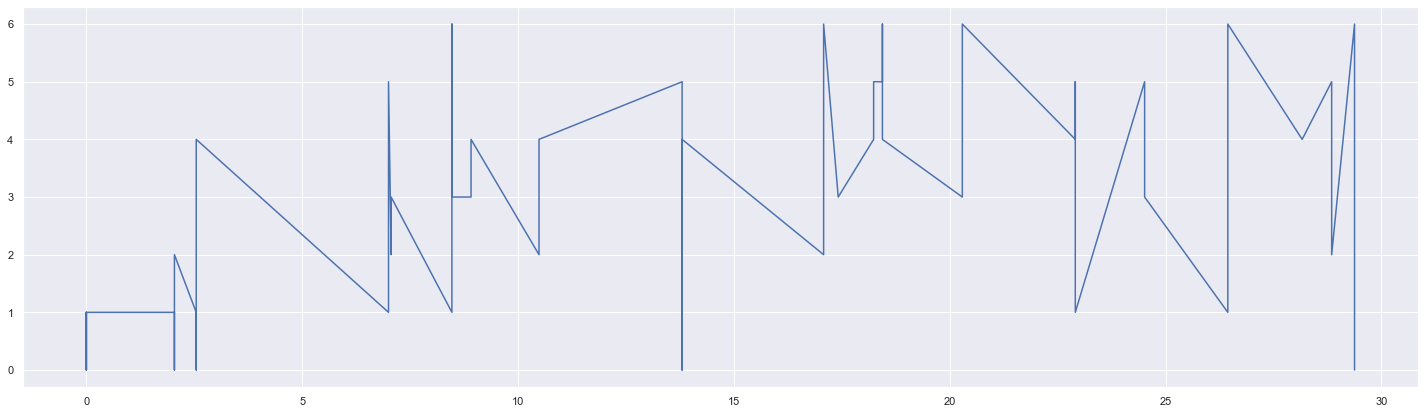

In [58]:
"""
Bank renege example
Covers:
- Resources: Resource
- Condition events
Scenario:
  A counter with a random service time and customers who renege. Based on the program bank08.py from TheBank tutorial of SimPy 2. (KGM)
"""

import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

RANDOM_SEED = 42
NEW_CUSTOMERS = 20  # Total number of customers
INTERVAL_CUSTOMERS = 2.0  # Generate new customers roughly every x seconds
CAPACITY = 2
MIN_PATIENCE = 5  # Min. customer patience
MAX_PATIENCE = 10  # Max. customer patience
TOT_RENEGED = 0
TOT_COMPLETED = 0
TOT_CUSTOMER = 0
QUEUE=0
maxQUEUE=0
PRINTALL = 'N'
LOG = []


def source(env, number, interval, counter):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Cust%02d' % i, counter,i, time_in_bank=12.0)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counter,j, time_in_bank):
    global TOT_RENEGED, TOT_COMPLETED,TOT_CUSTOMER,QUEUE,maxQUEUE,LOG,cycle
    """Customer arrives, is served and leaves."""
    arrive = env.now
    if (PRINTALL == 'Y'):
        print(j,('--'*j),'%s: New at %7.4f - Queue=%s' % (name,arrive,QUEUE))
    TOT_CUSTOMER=TOT_CUSTOMER+1
    
    QUEUE=QUEUE+1
    LOG.loc[len(LOG)] = [arrive,QUEUE,""]
    if (QUEUE>maxQUEUE):
           maxQUEUE=QUEUE

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)
        wait = env.now - arrive

        if req in results:
            # We got to the counter
            if (PRINTALL == 'Y'):
                print(j,('---'*j),'%s: Serving. Waited %6.3f. Clock %7.4f - Queue=%s' % (name, wait,env.now,QUEUE))
            QUEUE=QUEUE-1
            LOG.loc[len(LOG)] = [arrive,QUEUE,""]

            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            cycle = env.now - arrive
            if (PRINTALL == 'Y'):
                print(j,('---'*j),'%s: Finished. Cycle %6.3f. Clock %7.4f - Queue=%s' % (name,cycle,env.now,QUEUE))
            LOG.loc[len(LOG)] = [arrive,QUEUE,cycle]
            TOT_COMPLETED=TOT_COMPLETED+1

        else:
            # We reneged
            if (PRINTALL == 'Y'):
                print(j,('---'*j),'%s: RENEGED after %d. Clock %7.4f - Queue=%s' % (name, wait,env.now,QUEUE))
            TOT_RENEGED = TOT_RENEGED +1 
            QUEUE=QUEUE-1
            LOG.loc[len(LOG)] = [arrive,QUEUE,""]

# Setup and start the simulation
print('Bank renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

LOGdata = {'time': [0], 'queue': [0],'cycle': [0]}
LOG = pd.DataFrame(data=LOGdata)
LOG=LOG.astype(float)

# Start processes and run
counter = simpy.Resource(env, CAPACITY)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

print('NEW_CUSTOMERS,INTERVAL_CUSTOMERS,CAPACITY,MIN_PATIENCE,MAX_PATIENCE')
print(NEW_CUSTOMERS,INTERVAL_CUSTOMERS,CAPACITY,MIN_PATIENCE,MAX_PATIENCE)
print('PRINTALL:',PRINTALL)
print('TOT_CUSTOMER:',TOT_CUSTOMER)
print('TOT_COMPLETED:',TOT_COMPLETED)
print('TOT_RENEGED:',TOT_RENEGED)
print('%SUCCESS:',TOT_COMPLETED/TOT_CUSTOMER)
print('maxQUEUE:',maxQUEUE)

# sns.set(rc={'figure.figsize':(25,7)})

LOG= LOG.sort_values(by=['time'])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(LOG['time'], LOG['queue'],'b-')
plt.show()

# LOG

# Carwash example

In [2]:
# Carwash example.
# Covers:
# - Waiting for other processes
# - Resources: Resource
# Scenario:
#   A carwash has a limited number of washing machines and defines a washing processes that takes some (random) time.
#   Car processes arrive at the carwash at a random time. If one washing machine is available, they start the washing process and wait for it
#   to finish. If not, they wait until they an use one.

import random
import simpy
import pandas 

RANDOM_SEED = 42
NUM_MACHINES = 2  # Number of machines in the carwash
WASHTIME = 5      # Minutes it takes to clean a car
T_INTER = 3       # Create a car every ~7 minutes
SIM_TIME = 20     # Simulation time in minutes

class Carwash(object):
#     carwash has a limited number of machines (NUM_MACHINES) to clean cars in parallel.  Cars have to request one of the machines. When they got one, they can start the washing processes and wait for it to finish (which     takes `washtime` minutes).
    def __init__(self, env, num_machines, washtime):
        self.env = env
        self.machine = simpy.Resource(env, num_machines)
        self.washtime = washtime

    def wash(self, car):
#     The washing processes. It takes a ``car`` processes and tries to clean it
        yield self.env.timeout(WASHTIME)
        print("Carwash removed %d%% of %s's dirt." %
              (random.randint(50, 99), car))

def car(env, name, cw):
#     """The car process (each car has a ``name``) arrives at the carwash (``cw``) and requests a cleaning machine.
#     It then starts the washing process, waits for it to finish and leaves to never come back ...
    print('%s arrives at the carwash at %.2f.' % (name, env.now))
    with cw.machine.request() as request:
        yield request

        print('%s enters the carwash at %.2f.' % (name, env.now))
        yield env.process(cw.wash(name))

        print('%s leaves the carwash at %.2f.' % (name, env.now))

def setup(env, num_machines, washtime, t_inter):
#     Create a carwash, a number of initial cars and keep creating cars approx. every ``t_inter`` minutes."""
    carwash = Carwash(env, num_machines, washtime)   # Create carwash
    for i in range(4):    
        env.process(car(env, 'Car %d' % i, carwash))   # Create 4 initial cars
    while True:
        yield env.timeout(random.randint(t_inter - 2, t_inter + 2))
        i += 1
        env.process(car(env, 'Car %d' % i, carwash))      # Create more cars while the simulation is running

# Setup and start the simulation
print('Carwash')
random.seed(RANDOM_SEED)  # This helps reproducing the results

env = simpy.Environment()   # Create an environment 
env.process(setup(env, NUM_MACHINES, WASHTIME, T_INTER))  #start the setup process
env.run(until=SIM_TIME) # Execute!

Carwash
Car 0 arrives at the carwash at 0.00.
Car 1 arrives at the carwash at 0.00.
Car 2 arrives at the carwash at 0.00.
Car 3 arrives at the carwash at 0.00.
Car 0 enters the carwash at 0.00.
Car 1 enters the carwash at 0.00.
Car 4 arrives at the carwash at 1.00.
Car 5 arrives at the carwash at 2.00.
Carwash removed 65% of Car 0's dirt.
Carwash removed 64% of Car 1's dirt.
Car 6 arrives at the carwash at 5.00.
Car 0 leaves the carwash at 5.00.
Car 1 leaves the carwash at 5.00.
Car 2 enters the carwash at 5.00.
Car 3 enters the carwash at 5.00.
Car 7 arrives at the carwash at 7.00.
Car 8 arrives at the carwash at 8.00.
Carwash removed 55% of Car 2's dirt.
Carwash removed 87% of Car 3's dirt.
Car 2 leaves the carwash at 10.00.
Car 3 leaves the carwash at 10.00.
Car 4 enters the carwash at 10.00.
Car 5 enters the carwash at 10.00.
Car 9 arrives at the carwash at 13.00.
Carwash removed 52% of Car 4's dirt.
Carwash removed 51% of Car 5's dirt.
Car 4 leaves the carwash at 15.00.
Car 5 leav

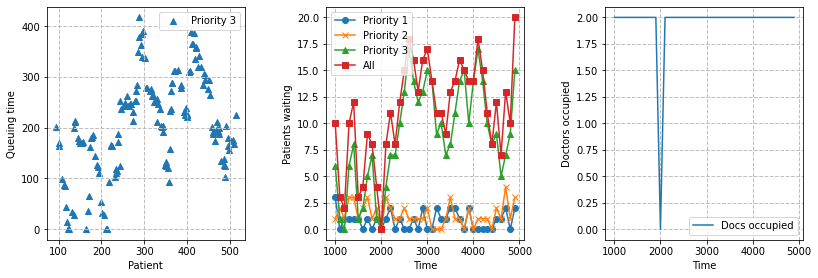

Patient-centred metrics:
------------------------

Lower quartile time in system by priority:
              q_time  consult_time  system_time
priority                                       
1.0         1.992342     15.926644    21.865081
2.0         5.578717     12.758018    24.994834
3.0       153.407459     11.890578   170.242473

Median time in system by priority:
              q_time  consult_time  system_time
priority                                       
1.0         6.050268     20.396865    26.726589
2.0        16.671961     17.010086    35.152426
3.0       207.791963     17.518244   223.768665

Upper quartile time in system by priority:
              q_time  consult_time  system_time
priority                                       
1.0        10.253611     24.006992    31.301931
2.0        28.895416     23.141108    47.055957
3.0       272.779777     22.436220   290.884395

Maximum time in system by priority:
              q_time  consult_time  system_time
priority             

In [149]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

class Global_vars:
    """Storage of global variables. No object instance created"""
    
    appointment_time_mean = 18
    appointment_time_sd = 7
    audit_time = []
    audit_interval = 100
    audit_patients_in_ED = []
    audit_patients_waiting = []
    audit_patients_waiting_p1 = []
    audit_patients_waiting_p2 = []
    audit_patients_waiting_p3 = []
    audit_reources_used = []
    inter_arrival_time = 10
    number_of_docs = 2
    patient_count = 0
    patients_waiting = 0
    patients_waiting_by_priority = [0, 0, 0]
    patient_queuing_results = pd.DataFrame(columns=['priority', 'q_time', 'consult_time'])
    results = pd.DataFrame()
    sim_duration = 5000
    warm_up = 1000

class Model:
    """ The model object holds the model and the methods directly relevant to the model."""
    
    def __init__(self):
        """Creates instance of SimPy model environemnt"""
        
        self.env = simpy.Environment()

    def build_audit_results(self):
        """Compiles audit results into dataframe held in Glov_vars"""
        
        Global_vars.results['time'] = Global_vars.audit_time
        
        Global_vars.results['patients in ED'] = (
            Global_vars.audit_patients_in_ED)
        
        Global_vars.results['all patients waiting'] = (
            Global_vars.audit_patients_waiting)
        
        Global_vars.results['priority 1 patients waiting'] = (
            Global_vars.audit_patients_waiting_p1)
        
        Global_vars.results['priority 2 patients waiting'] = (
            Global_vars.audit_patients_waiting_p2)
        
        Global_vars.results['priority 3 patients waiting'] = (
            Global_vars.audit_patients_waiting_p3)
        
        Global_vars.results['resources occupied'] = (
            Global_vars.audit_reources_used)

    def chart(self):
        """Plots results at end of run"""
        
        # Define figure size and defintion
        fig = plt.figure(figsize=(12, 4.5))
        # Create two charts side by side

        # Figure 1: patient level results
        ax1 = fig.add_subplot(131)  # 1 row, 3 cols, chart position 1
        x = Global_vars.patient_queuing_results.index
        # Chart loops through 3 priorites
        markers = ['o', 'x', '^']
        for priority in range(1, 4):
            x = (Global_vars.patient_queuing_results[Global_vars.patient_queuing_results
                                                     ['priority'] == priority].index)
            
            y = (Global_vars.patient_queuing_results
                 [Global_vars.patient_queuing_results['priority'] == priority]['q_time'])
            
        ax1.scatter(x, y, marker=markers[priority - 1], label='Priority ' + str(priority))
        ax1.set_xlabel('Patient')
        ax1.set_ylabel('Queuing time')
        ax1.legend()
        ax1.grid(True, which='both', lw=1, ls='--', c='.75')

        # Figure 2: ED level queuing results
        ax2 = fig.add_subplot(132)  # 1 row, 3 cols, chart position 2
        x = Global_vars.results['time']
        y1 = Global_vars.results['priority 1 patients waiting']
        y2 = Global_vars.results['priority 2 patients waiting']
        y3 = Global_vars.results['priority 3 patients waiting']
        y4 = Global_vars.results['all patients waiting']
        ax2.plot(x, y1, marker='o', label='Priority 1')
        ax2.plot(x, y2, marker='x', label='Priority 2')
        ax2.plot(x, y3, marker='^', label='Priority 3')
        ax2.plot(x, y4, marker='s', label='All')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Patients waiting')
        ax2.legend()
        ax2.grid(True, which='both', lw=1, ls='--', c='.75')

        # Figure 3: ED staff usage
        ax3 = fig.add_subplot(133)  # 1 row, 3 cols, chart position 3
        x = Global_vars.results['time']
        y = Global_vars.results['resources occupied']
        ax3.plot(x, y, label='Docs occupied')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Doctors occupied')
        ax3.legend()
        ax3.grid(True, which='both', lw=1, ls='--', c='.75')

        # Create plot
        plt.tight_layout(pad=3)
        plt.show()

    def perform_audit(self):
        """Monitors modelled ED at regular intervals (as defined by audit 
        interval in global_vars)"""

        # Delay before first aurdit if length of warm-up
        yield self.env.timeout(Global_vars.warm_up)
        # The trigger repeated audits
        while True:
            # Record time
            Global_vars.audit_time.append(self.env.now)
            # Record patients waiting by referencing global variables
            Global_vars.audit_patients_waiting.append(Global_vars.patients_waiting)
            
            (Global_vars.audit_patients_waiting_p1.append
             (Global_vars.patients_waiting_by_priority[0]))
            
            (Global_vars.audit_patients_waiting_p2.append
             (Global_vars.patients_waiting_by_priority[1]))
            
            (Global_vars.audit_patients_waiting_p3.append
             (Global_vars.patients_waiting_by_priority[2]))
            
            # Record patients waiting by asking length of dictionary of all patients 
            # (another way of doing things)
            Global_vars.audit_patients_in_ED.append(len(Patient.all_patients))
            # Record resources occupied
            Global_vars.audit_reources_used.append(self.doc_resources.docs.count)
            # Trigger next audit after interval
            yield self.env.timeout(Global_vars.audit_interval)

    def run(self):
        """Runs the model: Sets up resources, initialises model process, and starts
        running the model environment. At the end of the run raw model data is saved
        to file, and summary figure and results are displayed."""
        
        # Set up resources
        self.doc_resources = Resources(self.env, Global_vars.number_of_docs)
        # Initialise processes that will run on model run
        self.env.process(self.trigger_admissions())
        self.env.process(self.perform_audit())
        # Run
        self.env.run(until=Global_vars.sim_duration)
        
        # End of simulation run. Build and save results.
        # The saved results are the raw audit data
        Global_vars.patient_queuing_results.to_csv('patient results.csv')
        self.build_audit_results()
        Global_vars.results.to_csv('operational results.csv')
        # Plot a chart of results
        self.chart()
        # Pront text summary of results
        self.summarise()

    def see_doc(self, p):
        """Mangages waiting for doctor resorce. Records time waiting to see doc""" 
        
        with self.doc_resources.docs.request(priority=p.priority) as req:
            Global_vars.patients_waiting += 1
            # Wait for resources to become available
            yield req
            # Resources now available
            # Record queuing times in patient object and Global dataframe
            p.time_see_doc = self.env.now
            p.queuing_time = self.env.now - p.time_in
            _results = [p.priority, p.queuing_time]
            yield self.env.timeout(p.consulation_time)
            _results.append(self.env.now - p.time_see_doc)
            # Record results if warm-up complete
            if self.env.now >= Global_vars.warm_up:
                Global_vars.patient_queuing_results.loc[p.id] = _results
            # Reduce patients waiting counts
            Global_vars.patients_waiting_by_priority[p.priority - 1] -= 1
            Global_vars.patients_waiting -= 1
            # Delete patient (removal from patient dictionary removes only
            # reference to patient and Python then automatically cleans up)
            del Patient.all_patients[p.id]
            
    def summarise(self):
        """Produces displayed text summary of model run"""
        
        # For each patient calaculate time in system as time in queue + time with doc
        Global_vars.patient_queuing_results['system_time'] =  (
                Global_vars.patient_queuing_results['q_time'] +
                Global_vars.patient_queuing_results['consult_time'])
        
        # Disply results summaries
        print ('Patient-centred metrics:')
        print ('------------------------\n')
        print ('Lower quartile time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(0.25))
        print ('\nMedian time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(0.50))
        print ('\nUpper quartile time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(0.75))
        print ('\nMaximum time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(1))
        print ('\nED-centred metrics:')
        print ('------------------\n')
        print (Global_vars.results.describe())
        
    def trigger_admissions(self):
        """Produces patient arrivals. Initialises a patient object (from Patient class), 
        passes the patient over to the see_doc method, and sets the next admission
        time/event"""
        
        # While loop continues generating new patients
        while True:
            # Initialise new patient (pass environment to be used to record
            # current simulation time)
            p = Patient(self.env)
            # Add patient to dictionary of patients
            Patient.all_patients[p.id] = p
            # Pass patient to see_doc method
            self.env.process(self.see_doc(p))
            # Sample time for next asmissions
            next_admission = random.expovariate(1 / Global_vars.inter_arrival_time)
            # Schedule next admission
            yield self.env.timeout(next_admission)


class Patient:
    """Class of patient objects. The class also holds a list of all patient objects in 
    all_patients dictionary"""
        
    # The following dictionaries store patients
    all_patients = {}

    # New patient instance
    def __init__(self, env):
        Global_vars.patient_count += 1
        
        self.consulation_time = (
            random.normalvariate(Global_vars.appointment_time_mean,
                                 Global_vars.appointment_time_sd))
        
        self.consulation_time = 0 if self.consulation_time < 0 else self.consulation_time
        self.id = Global_vars.patient_count
        self.priority = random.randint(1, 3)
        self.queuing_time = 0
        self.time_in = env.now
        self.time_see_doc = 0
        self.time_out = 0
        # 1 is subtracted from priority to align priority (1-3) with zero indexed list (0-2)
        Global_vars.patients_waiting_by_priority[self.priority - 1] += 1

class Resources:
    """Resources required by processes in the model.
    Just holds doctors as the only limiting resorce"""
    
    def __init__(self, env, number_of_docs):
        self.docs = simpy.PriorityResource(env, capacity=number_of_docs)

if __name__ == '__main__':
    """Start model running"""
    model = Model() # calls method to set up model envrionment
    model.run() # calls method to run model